# Make Data Count: Exploratory Data Analysis

Comprehensive EDA of the competition data to understand:
- Label distribution and patterns
- Dataset reference types and sources
- Paper content structure
- Missing data patterns

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import re
from collections import Counter
from urllib.parse import urlparse
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

## 1. Load and Examine Training Labels

In [3]:
# Load training labels
train_labels = pd.read_csv('../data/train_labels.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

print(f"Training labels shape: {train_labels.shape}")
print(f"Sample submission shape: {sample_submission.shape}")
print("\nTraining labels columns:", train_labels.columns.tolist())
print("Sample submission columns:", sample_submission.columns.tolist())

Training labels shape: (1028, 3)
Sample submission shape: (14, 4)

Training labels columns: ['article_id', 'dataset_id', 'type']
Sample submission columns: ['row_id', 'article_id', 'dataset_id', 'type']


In [4]:
# Basic statistics
print("=== TRAINING LABELS OVERVIEW ===")
print(train_labels.head(10))
print("\n=== BASIC INFO ===")
print(train_labels.info())
print("\n=== VALUE COUNTS ===")
print("Type distribution:")
print(train_labels['type'].value_counts())
print(f"\nUnique articles: {train_labels['article_id'].nunique()}")
print(f"Unique datasets: {train_labels['dataset_id'].nunique()}")

=== TRAINING LABELS OVERVIEW ===
               article_id                      dataset_id     type
0    10.1002_2017jc013030  https://doi.org/10.17882/49388  Primary
1  10.1002_anie.201916483                         Missing  Missing
2  10.1002_anie.202005531                         Missing  Missing
3  10.1002_anie.202007717                         Missing  Missing
4  10.1002_chem.201902131                         Missing  Missing
5  10.1002_chem.201903120                         Missing  Missing
6  10.1002_chem.202000235                         Missing  Missing
7  10.1002_chem.202001412                         Missing  Missing
8  10.1002_chem.202001668                         Missing  Missing
9  10.1002_chem.202003167                         Missing  Missing

=== BASIC INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  1028 no

## 2. Label Distribution Analysis

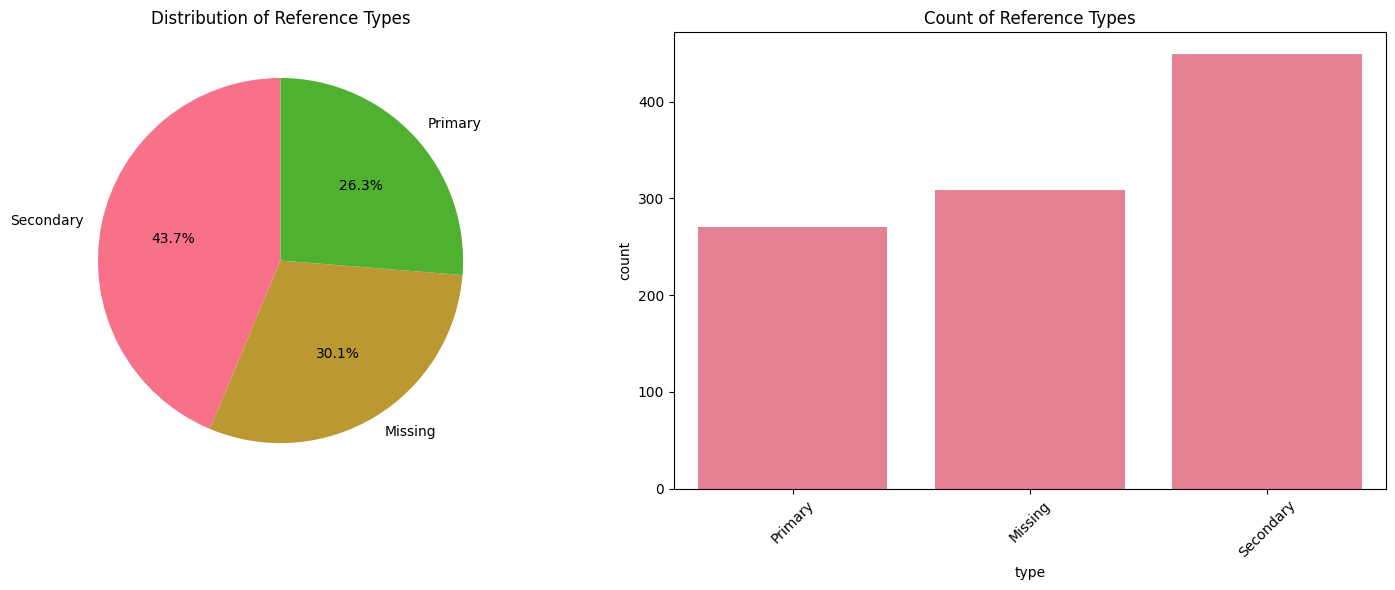

Reference type percentages:
type
Secondary    43.68
Missing      30.06
Primary      26.26
Name: count, dtype: float64


In [5]:
# Visualize type distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
type_counts = train_labels['type'].value_counts()
axes[0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribution of Reference Types')

# Bar chart
sns.countplot(data=train_labels, x='type', ax=axes[1])
axes[1].set_title('Count of Reference Types')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print percentages
print("Reference type percentages:")
print((train_labels['type'].value_counts() / len(train_labels) * 100).round(2))

In [6]:
# Analyze non-missing entries
non_missing = train_labels[train_labels['type'] != 'Missing'].copy()
print(f"Non-missing entries: {len(non_missing)} ({len(non_missing)/len(train_labels)*100:.1f}%)")
print(f"Missing entries: {len(train_labels) - len(non_missing)} ({(len(train_labels) - len(non_missing))/len(train_labels)*100:.1f}%)")

if len(non_missing) > 0:
    print("\nNon-missing type distribution:")
    print(non_missing['type'].value_counts())
    print("\nNon-missing type percentages:")
    print((non_missing['type'].value_counts() / len(non_missing) * 100).round(2))

Non-missing entries: 719 (69.9%)
Missing entries: 309 (30.1%)

Non-missing type distribution:
type
Secondary    449
Primary      270
Name: count, dtype: int64

Non-missing type percentages:
type
Secondary    62.45
Primary      37.55
Name: count, dtype: float64


## 3. Dataset Reference Analysis

In [7]:
# Analyze dataset URLs/DOIs
dataset_ids = non_missing['dataset_id'].dropna().unique()
print(f"Unique dataset references: {len(dataset_ids)}")

# Analyze URL patterns
url_domains = []
doi_patterns = []

for dataset_id in dataset_ids:
    if pd.notna(dataset_id) and dataset_id != 'Missing':
        if 'doi.org' in dataset_id:
            # Extract DOI pattern
            if '/10.' in dataset_id:
                doi_part = dataset_id.split('/10.')[1].split('/')[0]
                doi_patterns.append(f"10.{doi_part}")
        else:
            # Extract domain
            try:
                domain = urlparse(dataset_id).netloc
                if domain:
                    url_domains.append(domain)
            except:
                pass

print(f"\nTop DOI prefixes:")
doi_counter = Counter(doi_patterns)
for doi, count in doi_counter.most_common(10):
    print(f"  {doi}: {count}")

print(f"\nTop URL domains:")
domain_counter = Counter(url_domains)
for domain, count in domain_counter.most_common(10):
    print(f"  {domain}: {count}")

Unique dataset references: 719

Top DOI prefixes:
  10.5061: 79
  10.15468: 38
  10.5066: 36
  10.5281: 22
  10.3886: 18
  10.5256: 18
  10.1594: 15
  10.7937: 12
  10.6073: 10
  10.17882: 9

Top URL domains:


Data repository distribution:
  Other: 607
  Dryad: 79
  Zenodo: 22
  TCIA: 11


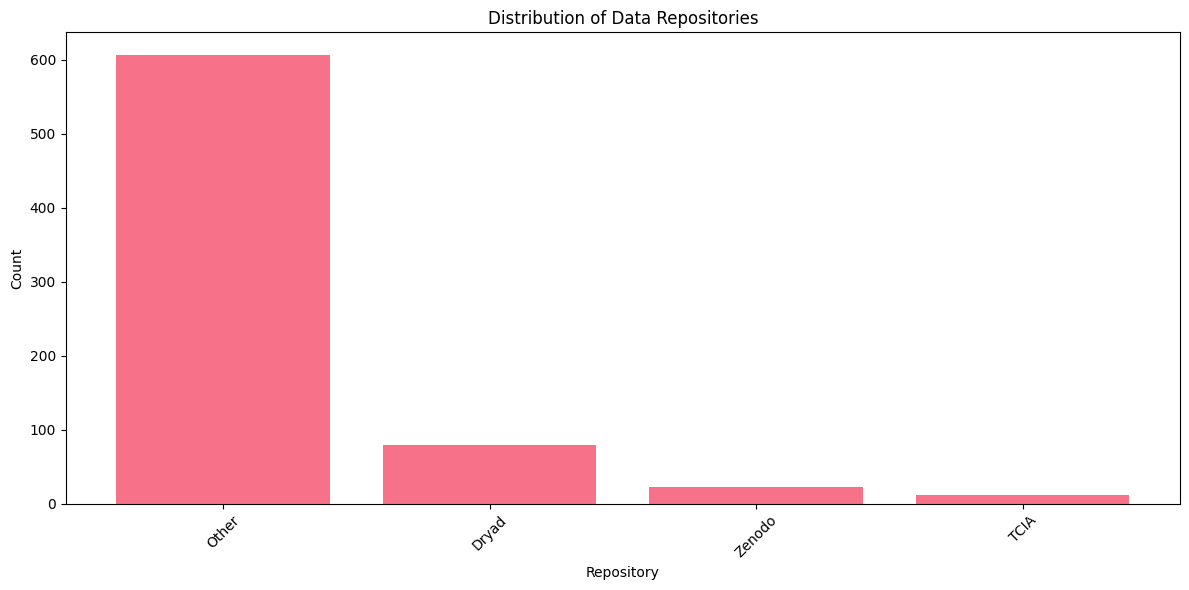

In [8]:
# Visualize top data repositories
all_sources = []
for dataset_id in dataset_ids:
    if pd.notna(dataset_id) and dataset_id != 'Missing':
        if 'dryad' in dataset_id.lower():
            all_sources.append('Dryad')
        elif 'zenodo' in dataset_id.lower():
            all_sources.append('Zenodo')
        elif 'figshare' in dataset_id.lower():
            all_sources.append('Figshare')
        elif 'github' in dataset_id.lower():
            all_sources.append('GitHub')
        elif 'usgs' in dataset_id.lower():
            all_sources.append('USGS')
        elif 'tcia' in dataset_id.lower():
            all_sources.append('TCIA')
        elif 'ncbi' in dataset_id.lower():
            all_sources.append('NCBI')
        else:
            all_sources.append('Other')

source_counts = Counter(all_sources)
print("Data repository distribution:")
for source, count in source_counts.most_common():
    print(f"  {source}: {count}")

# Plot repository distribution
if source_counts:
    plt.figure(figsize=(12, 6))
    sources, counts = zip(*source_counts.most_common())
    plt.bar(sources, counts)
    plt.title('Distribution of Data Repositories')
    plt.xlabel('Repository')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 4. Article Analysis

Articles with references: 523
Average references per article: 1.97
Max references per article: 32

Distribution of references per article:
  1 references: 447 articles
  2 references: 30 articles
  3 references: 14 articles
  4 references: 6 articles
  5 references: 2 articles
  7 references: 1 articles
  8 references: 1 articles
  10 references: 2 articles
  11 references: 1 articles
  12 references: 1 articles
  13 references: 1 articles
  15 references: 1 articles
  16 references: 2 articles
  17 references: 1 articles
  18 references: 3 articles
  20 references: 1 articles
  22 references: 2 articles
  23 references: 1 articles
  25 references: 2 articles
  27 references: 1 articles
  29 references: 1 articles
  31 references: 1 articles
  32 references: 1 articles


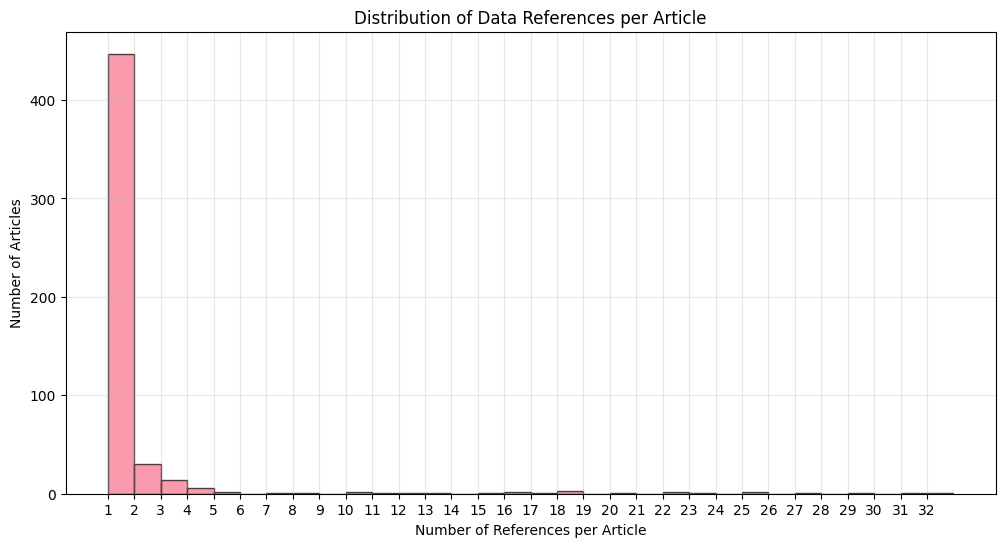

In [9]:
# Articles per reference count
article_ref_counts = train_labels.groupby('article_id').size()
print(f"Articles with references: {len(article_ref_counts)}")
print(f"Average references per article: {article_ref_counts.mean():.2f}")
print(f"Max references per article: {article_ref_counts.max()}")

print("\nDistribution of references per article:")
ref_dist = article_ref_counts.value_counts().sort_index()
for refs, count in ref_dist.items():
    print(f"  {refs} references: {count} articles")

# Plot reference distribution
plt.figure(figsize=(12, 6))
plt.hist(article_ref_counts, bins=range(1, article_ref_counts.max()+2), alpha=0.7, edgecolor='black')
plt.xlabel('Number of References per Article')
plt.ylabel('Number of Articles')
plt.title('Distribution of Data References per Article')
plt.xticks(range(1, article_ref_counts.max()+1))
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# Analyze articles with multiple references
multi_ref_articles = article_ref_counts[article_ref_counts > 1]
if len(multi_ref_articles) > 0:
    print(f"Articles with multiple references: {len(multi_ref_articles)}")
    
    # Look at reference types for multi-reference articles
    sample_multi = multi_ref_articles.head().index
    print("\nSample multi-reference articles:")
    for article_id in sample_multi:
        article_refs = train_labels[train_labels['article_id'] == article_id]
        print(f"\n{article_id}:")
        for _, row in article_refs.iterrows():
            print(f"  - {row['type']}: {row['dataset_id']}")

Articles with multiple references: 76

Sample multi-reference articles:

10.1002_mp.14424:
  - Secondary: https://doi.org/10.7937/k9/tcia.2015.pf0m9rei
  - Primary: https://doi.org/10.7937/tcia.2020.6c7y-gq39

10.1007_s00259-022-06053-8:
  - Secondary: https://doi.org/10.7937/k9/tcia.2017.7hs46erv
  - Secondary: https://doi.org/10.7937/tcia.2019.30ilqfcl

10.1007_s00382-022-06361-7:
  - Primary: https://doi.org/10.6075/j0154fjj
  - Primary: https://doi.org/10.6075/j089161b

10.1016_j.ast.2022.107401:
  - Primary: https://doi.org/10.17862/cranfield.rd.19146182
  - Primary: https://doi.org/10.17862/cranfield.rd.19146182.v1

10.1016_j.fuel.2022.125768:
  - Primary: https://doi.org/10.11583/dtu.20555586
  - Primary: https://doi.org/10.11583/dtu.20555586.v3


## 5. Paper Content Analysis

In [11]:
# Explore paper directory structure
train_dir = Path('../data/train')
test_dir = Path('../data/test')

print("Training data structure:")
if train_dir.exists():
    subdirs = [d for d in train_dir.iterdir() if d.is_dir()]
    for subdir in subdirs[:5]:  # Show first 5 subdirectories
        files = list(subdir.iterdir())
        print(f"  {subdir.name}: {len(files)} files")
        if files:
            print(f"    Sample files: {[f.name for f in files[:3]]}")
    print(f"  Total article directories: {len(subdirs)}")
else:
    print("  Train directory not found")

Training data structure:
  XML: 400 files
    Sample files: ['10.1080_21645515.2023.2189598.xml', '10.21105_joss.04237.xml', '10.1186_s12860-020-00261-6.xml']
  PDF: 524 files
    Sample files: ['10.1590_fst.36617.pdf', '10.1590_0104-4060.59642.pdf', '10.1002_ece3.9627.pdf']
  Total article directories: 2


In [12]:
# Sample a few papers to understand structure
def analyze_paper_structure(paper_dir):
    """Analyze the structure of a single paper directory"""
    files = list(paper_dir.iterdir())
    file_types = {}
    
    for file in files:
        ext = file.suffix.lower()
        file_types[ext] = file_types.get(ext, 0) + 1
    
    return file_types, files

if train_dir.exists():
    sample_papers = list(train_dir.iterdir())[:3]
    
    for paper_dir in sample_papers:
        if paper_dir.is_dir():
            file_types, files = analyze_paper_structure(paper_dir)
            print(f"\n=== {paper_dir.name} ===")
            print(f"File types: {file_types}")
            
            # Try to read a sample file
            for file in files[:2]:
                try:
                    if file.suffix.lower() in ['.xml', '.txt']:
                        with open(file, 'r', encoding='utf-8') as f:
                            content = f.read()[:500]
                            print(f"\nSample from {file.name} ({len(content)} chars):")
                            print(content[:200] + "..." if len(content) > 200 else content)
                        break
                except Exception as e:
                    print(f"Could not read {file.name}: {e}")


=== XML ===
File types: {'.xml': 400}

Sample from 10.1080_21645515.2023.2189598.xml (500 chars):
<!DOCTYPE article PUBLIC "-//NLM//DTD JATS (Z39.96) Journal Archiving and Interchange DTD with MathML3 v1.3 20210610//EN" "JATS-archivearticle1-3-mathml3.dtd"> 
<article xmlns:mml="http://www.w3.org/1...

=== PDF ===
File types: {'.pdf': 524}


## 6. Missing Pattern Analysis

In [13]:
# Analyze missing patterns
missing_articles = train_labels[train_labels['type'] == 'Missing']['article_id'].unique()
referenced_articles = train_labels[train_labels['type'] != 'Missing']['article_id'].unique()

print(f"Articles with only missing references: {len(missing_articles)}")
print(f"Articles with at least one reference: {len(referenced_articles)}")

# Check if any articles have both missing and non-missing
overlap = set(missing_articles) & set(referenced_articles)
print(f"Articles with both missing and non-missing references: {len(overlap)}")

if overlap:
    print("\nSample articles with mixed references:")
    for article_id in list(overlap)[:3]:
        article_refs = train_labels[train_labels['article_id'] == article_id]
        print(f"\n{article_id}:")
        for _, row in article_refs.iterrows():
            print(f"  - {row['type']}: {row['dataset_id']}")

Articles with only missing references: 309
Articles with at least one reference: 214
Articles with both missing and non-missing references: 0


## 7. Publication Pattern Analysis

Top journals by number of articles:
  other: 999
  ece3: 9
  chem: 6
  anie: 3
  mp: 2
  ejoc: 2
  ecs2: 2
  esp: 2
  2017jc013030: 1
  ejic: 1


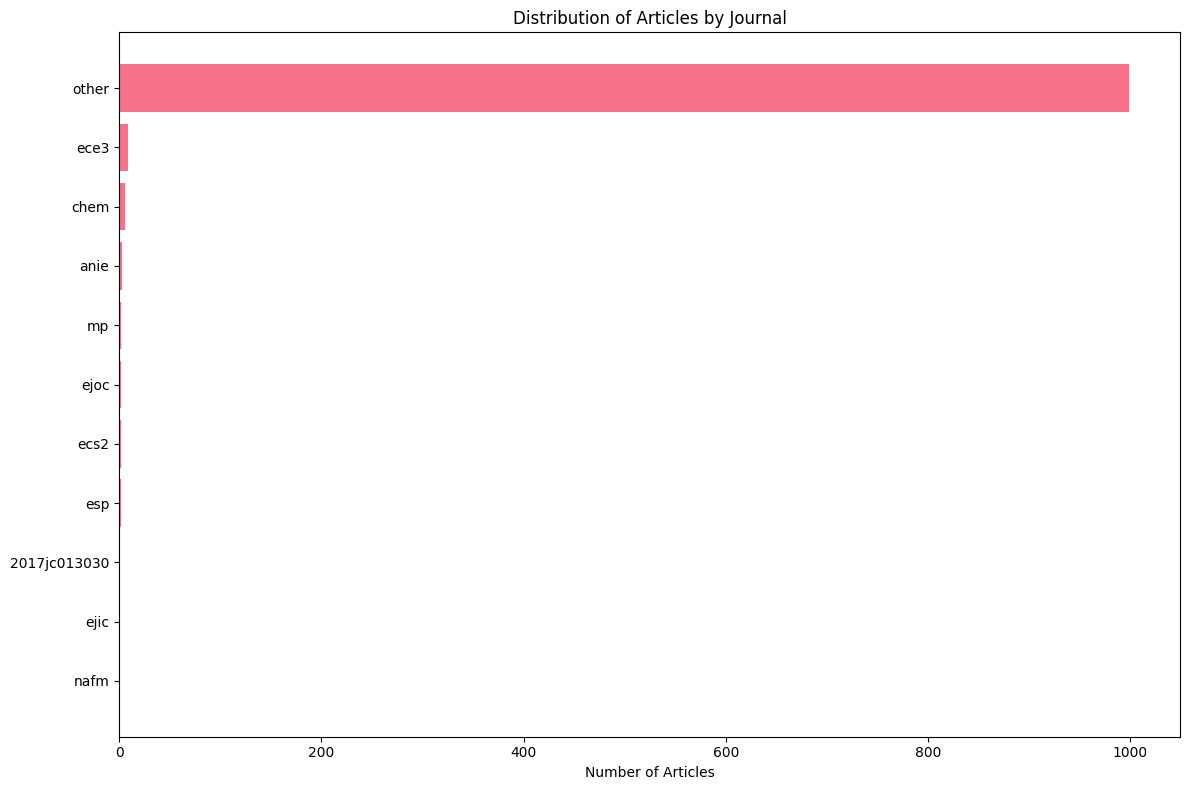

In [14]:
# Extract journal/publisher info from article IDs
def extract_journal_info(article_id):
    """Extract journal information from DOI-style article ID"""
    if '10.1002' in article_id:
        # Wiley journals
        parts = article_id.split('_')
        if len(parts) >= 2:
            return parts[1].split('.')[0]  # Journal abbreviation
    return 'other'

# Analyze journal distribution
journals = train_labels['article_id'].apply(extract_journal_info)
journal_counts = journals.value_counts()

print("Top journals by number of articles:")
for journal, count in journal_counts.head(10).items():
    print(f"  {journal}: {count}")

# Plot journal distribution
plt.figure(figsize=(12, 8))
top_journals = journal_counts.head(15)
plt.barh(range(len(top_journals)), top_journals.values)
plt.yticks(range(len(top_journals)), top_journals.index)
plt.xlabel('Number of Articles')
plt.title('Distribution of Articles by Journal')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Summary and Key Insights

In [15]:
print("=== KEY INSIGHTS ===")
print(f"\n1. Dataset Size:")
print(f"   - Total entries: {len(train_labels):,}")
print(f"   - Unique articles: {train_labels['article_id'].nunique():,}")
print(f"   - Unique datasets: {train_labels['dataset_id'].nunique():,}")

print(f"\n2. Label Distribution:")
type_pcts = (train_labels['type'].value_counts() / len(train_labels) * 100).round(1)
for ref_type, pct in type_pcts.items():
    print(f"   - {ref_type}: {pct}%")

print(f"\n3. Reference Patterns:")
print(f"   - Articles with multiple references: {len(multi_ref_articles) if 'multi_ref_articles' in locals() else 0}")
print(f"   - Average references per article: {article_ref_counts.mean():.2f}")

print(f"\n4. Data Repositories:")
if 'source_counts' in locals():
    for source, count in list(source_counts.most_common(5)):
        print(f"   - {source}: {count}")

print(f"\n5. Challenge Areas:")
print(f"   - High proportion of missing references ({type_pcts.get('Missing', 0)}%)")
print(f"   - Multiple reference types per paper")
print(f"   - Diverse data repository formats")
print(f"   - Need to extract from various paper formats (XML, PDF, etc.)")

=== KEY INSIGHTS ===

1. Dataset Size:
   - Total entries: 1,028
   - Unique articles: 523
   - Unique datasets: 720

2. Label Distribution:
   - Secondary: 43.7%
   - Missing: 30.1%
   - Primary: 26.3%

3. Reference Patterns:
   - Articles with multiple references: 76
   - Average references per article: 1.97

4. Data Repositories:
   - Other: 607
   - Dryad: 79
   - Zenodo: 22
   - TCIA: 11

5. Challenge Areas:
   - High proportion of missing references (30.1%)
   - Multiple reference types per paper
   - Diverse data repository formats
   - Need to extract from various paper formats (XML, PDF, etc.)
